In [9]:
import sys
from pathlib import Path
from typing import Any, Callable, Dict, Tuple

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import pandas as pd

sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, MeasurementDataset, MeasurementLoader

data_dir = Path("measurements")
print(f"Data resides in: {data_dir.resolve()}")

Data resides in: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_polish/tfim_16/measurements


In [10]:
class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))
        self.num_visible = num_visible
        self.num_hidden = num_hidden

    def forward(self, cond: torch.Tensor):
        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)
        return torch.split(x, [self.num_visible, self.num_visible, self.num_hidden, self.num_hidden], dim=-1)

class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))

        self.conditioner = Conditioner(num_visible, num_hidden, cond_dim, conditioner_width)
        self.initialize_weights()

    # --- FIXED: Now accepts the arguments your training script passes ---
    def initialize_weights(self, w_mean: float = 0.0, w_std: float = 0.01, bias_val: float = 0.0):
        nn.init.normal_(self.W, mean=w_mean, std=w_std)
        nn.init.constant_(self.b, bias_val)
        nn.init.constant_(self.c, bias_val)

    def _free_energy(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor) -> torch.Tensor:
        """
        Symmetrized Free Energy: FE_sym(v) = -T * log( exp(-FE(v)/T) + exp(-FE(1-v)/T) )
        """
        v = v.to(dtype=self.W.dtype, device=self.W.device)
        v_W = v @ self.W
        W_sum = self.W.sum(dim=0)

        # 1. State v
        linear_v = v_W + c_mod
        term2_v = F.softplus(linear_v).sum(dim=-1)
        term1_v = -(v * b_mod).sum(dim=-1)
        fe_v = term1_v - term2_v

        # 2. State 1-v (flipped)
        linear_flip = W_sum.unsqueeze(0) - v_W + c_mod
        term2_f = F.softplus(linear_flip).sum(dim=-1)
        term1_f = -((1.0 - v) * b_mod).sum(dim=-1)
        fe_flipped = term1_f - term2_f

        # Combine
        stacked = torch.stack([-fe_v, -fe_flipped], dim=-1)
        return -self.T * torch.logsumexp(stacked / self.T, dim=-1)

    def _compute_effective_biases(self, cond: torch.Tensor):
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        if cond.dim() == 1:
            b_mod = (1.0 + gamma_b) * self.b + beta_b
            c_mod = (1.0 + gamma_c) * self.c + beta_c
        else:
            b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
            c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    def _gibbs_step(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor, T: float, rng: torch.Generator):
        p_h = torch.sigmoid((v @ self.W + c_mod) / T)
        h = torch.bernoulli(p_h, generator=rng)
        p_v = torch.sigmoid((h @ self.W.t() + b_mod) / T)
        return torch.bernoulli(p_v, generator=rng)

    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        # Returns log(Psi) = 0.5 * log(P)
        b_mod, c_mod = self._compute_effective_biases(cond)
        return -0.5 * self._free_energy(v, b_mod, c_mod) / self.T

    def forward(self, batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
        v_data, _, cond = batch
        v_data = v_data.to(device=self.W.device, dtype=self.W.dtype)
        cond = cond.to(device=self.W.device, dtype=self.W.dtype)
        rng = aux_vars.get("rng")

        b_mod, c_mod = self._compute_effective_biases(cond)
        v_model = v_data.clone()

        noise_frac = aux_vars.get("noise_frac", 0.0)
        if noise_frac > 0:
            n_noise = int(v_data.shape[0] * noise_frac)
            if n_noise > 0:
                v_model[:n_noise] = torch.bernoulli(torch.full_like(v_model[:n_noise], 0.5), generator=rng)

        for _ in range(self.k):
            v_model = self._gibbs_step(v_model, b_mod, c_mod, self.T, rng)
        v_model = v_model.detach()

        fe_data = self._free_energy(v_data, b_mod, c_mod)
        fe_model = self._free_energy(v_model, b_mod, c_mod)
        loss = (fe_data - fe_model).mean()

        # Calculate aux metrics for logging
        n_flips = (v_data != v_model).float().sum()
        flip_rate = n_flips / v_data.numel()
        max_bias = torch.max(torch.abs(b_mod)).detach()

        return loss, {
            "flip_rate": flip_rate,
            "max_bias": max_bias,
            "free_energy_mean": (fe_data - fe_model).mean().detach(),
            "free_energy_std": (fe_data - fe_model).std(unbiased=False).detach()
        }

    @torch.no_grad()
    def generate(self, cond: torch.Tensor, T_schedule: torch.Tensor, rng: torch.Generator) -> torch.Tensor:
        if cond.dim() == 1: cond = cond.view(-1, 1)
        cond = cond.to(self.W.device, dtype=self.W.dtype)
        b_mod, c_mod = self._compute_effective_biases(cond)
        B = cond.shape[0]
        v = (torch.rand((B, self.num_visible), generator=rng, device=cond.device) < 0.5).float()
        if T_schedule.dim() == 0: T_schedule = T_schedule.view(1)
        for i in range(int(T_schedule.shape[0])):
            v = self._gibbs_step(v, b_mod, c_mod, float(T_schedule[i]), rng)
        return v

In [11]:
def compute_renyi_entropy(samples: torch.Tensor, subs_size: int,
                          log_score_fn: Callable[[torch.Tensor], torch.Tensor]) -> float:

    n_samples = samples.shape[0]
    half = n_samples // 2
    if half == 0:
        return 0.0

    ref_1 = samples[:half]
    ref_2 = samples[half:2 * half]

    ref_1_score = log_score_fn(ref_1)
    ref_2_score = log_score_fn(ref_2)

    slice_idx = torch.arange(subs_size, samples.shape[1], device=samples.device)

    swap_1 = ref_1.clone()
    swap_1[:, slice_idx] = ref_2[:, slice_idx]
    swap_2 = ref_2.clone()
    swap_2[:, slice_idx] = ref_1[:, slice_idx]

    swap_1_score = log_score_fn(swap_1)
    swap_2_score = log_score_fn(swap_2)

    log_swap_ratio = swap_1_score + swap_2_score - ref_1_score - ref_2_score
    swap_exp = torch.exp(log_swap_ratio).mean().item()

    if swap_exp <= 1e-12:
        return 0.0

    renyi_entropy = -math.log(swap_exp)
    return renyi_entropy


def monitor_entropy(model, device, chain_len, monitor_seed=1234, n_samples=2000):
    model.eval()

    cond_val = 1.0
    cond_gen = torch.tensor([[cond_val]], device=device).expand(n_samples, -1)
    cond_score = torch.tensor([[cond_val]], device=device)

    T_schedule = torch.full((model.k,), model.T, device=device)
    rng = torch.Generator(device=device).manual_seed(monitor_seed)
    samples = model.generate(cond_gen, T_schedule, rng)

    scorer = lambda v: model.log_score(v, cond_score)
    half_chain = chain_len // 2
    s2 = compute_renyi_entropy(samples, half_chain, scorer)

    model.train()
    return s2

In [12]:
def train_step(model: nn.Module, optimizer: torch.optim.Optimizer,
               batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
    optimizer.zero_grad(set_to_none=True)
    loss, aux = model(batch, aux_vars)
    loss.backward()
    optimizer.step()
    return loss.detach(), aux

def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None: center_step = steps / 2.0
    def curve_fn(step: int) -> float:
        s = min(step, steps)
        return float(low + (high - low) / (1.0 + math.exp(falloff * (s - center_step))))
    return curve_fn

def train(model: nn.Module, optimizer: torch.optim.Optimizer, loader, num_epochs: int,
          rng: torch.Generator, monitor_seed: int, l2_strength: float, noise_frac: float,
          lr_schedule_fn: Callable[[int], float], ds: MeasurementDataset):

    metrics: Dict[int, Any] = {}
    global_step = 0
    device = next(model.parameters()).device
    chain_length = ds.num_qubits

    header = f"{'Epoch':<6} | {'Loss':<9} | {'FE Mean':<8} | {'FE Std':<8} | {'LR':<8} | {'S2(L/2)':<8}"
    print(header)
    print("-" * len(header))

    for epoch in range(num_epochs):
        tot_loss = 0.0
        fe_mean = 0.0
        fe_std = 0.0

        for batch in loader:
            lr = float(lr_schedule_fn(global_step))
            for g in optimizer.param_groups:
                g["lr"] = lr

            aux_vars = { "rng": rng, "l2_strength": l2_strength, "noise_frac": noise_frac }
            loss, aux_out = train_step(model, optimizer, batch, aux_vars)

            tot_loss += float(loss)
            fe_mean = float(aux_out.get("free_energy_mean", 0.0))
            fe_std = float(aux_out.get("free_energy_std", 0.0))
            global_step += 1

        avg_loss = tot_loss / len(loader)
        lr_epoch = float(lr_schedule_fn(global_step))

        s2_curr = monitor_entropy(model, device, chain_length, monitor_seed=monitor_seed)

        metrics[epoch] = {
            'loss': avg_loss,
            'free_energy_mean': fe_mean,
            'free_energy_var': fe_std,
            'lr': lr_epoch,
            's2': s2_curr
        }

        print(f"{epoch + 1:<6} | {avg_loss:+.4f}   | {fe_mean:+.4f}   | {fe_std:.4f}   | "
              f"{lr_epoch:.5f}  | {s2_curr:.4f}")

    return model, metrics

In [13]:
CHAIN_LENGTH = 16
FILE_SAMPLES = 5_000_000
TRAIN_SAMPLES = 10_000

#h_support = [0.80, 1.00, 1.20]
h_support = [0.50, 0.80, 0.95, 1.00, 1.05, 1.20, 1.50]


file_names = [f"tfim_{CHAIN_LENGTH}_h{d:.2f}_{FILE_SAMPLES}.npz" for d in h_support]
file_paths = [data_dir / fn for fn in file_names]
samples_per_file = [TRAIN_SAMPLES] * len(file_paths)

print(f"System Size       : {CHAIN_LENGTH} spins (1D Chain)")
print(f"Support h         : {h_support}")

ds = MeasurementDataset(file_paths, load_fn=load_measurements_npz,
                        system_param_keys=["h"], samples_per_file=samples_per_file)

print(f"Samples Shape     : {tuple(ds.values.shape)}")
print(f"Conditions Shape  : {tuple(ds.system_params.shape)}")

System Size       : 16 spins (1D Chain)
Support h         : [0.5, 0.8, 0.95, 1.0, 1.05, 1.2, 1.5]
Samples Shape     : (70000, 16)
Conditions Shape  : (70000, 1)


In [14]:
# TRAINING CONFIG

batch_size        = 1024
num_visible       = ds.num_qubits

num_hidden        = 16
conditioner_width = 32  # increasing to 64 does not help much
l2_strength       = 0.0
num_epochs        = 200 # should be larger
k_steps           = 30  # works with only 15 too
init_lr           = 1e-2
final_lr          = init_lr * 0.01
noise_frac        = 1.0

SEED = 42
torch.manual_seed(SEED)
rng = torch.Generator().manual_seed(SEED)

loader = MeasurementLoader(dataset=ds, batch_size=batch_size, shuffle=True, drop_last=False, rng=rng)

model = ConditionalRBM(num_visible=num_visible, num_hidden=num_hidden, cond_dim=ds.system_params.shape[1],
                       conditioner_width=conditioner_width, k=k_steps, T=1.0)

model.initialize_weights(w_mean=0.0, w_std=0.01, bias_val=0.0)

optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

schedule_steps = num_epochs * len(loader)
lr_schedule_fn = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.001)

print(f"Training on {num_visible} qubits for {num_epochs} epochs (k={k_steps})...")

model, metrics = train(model=model, optimizer=optimizer, loader=loader, num_epochs=num_epochs,
                       rng=rng, monitor_seed=SEED, l2_strength=l2_strength, noise_frac=noise_frac,
                       lr_schedule_fn=lr_schedule_fn, ds=ds)

Training on 16 qubits for 200 epochs (k=30)...
Epoch  | Loss      | FE Mean  | FE Std   | LR       | S2(L/2) 
--------------------------------------------------------------
1      | -0.0497   | +0.4872   | 3.9077   | 0.00999  | 0.0099
2      | -0.0131   | -0.2855   | 3.4509   | 0.00999  | 0.0220
3      | +0.0080   | -0.2193   | 3.4469   | 0.00999  | 0.0545
4      | -0.0461   | -0.5623   | 3.6823   | 0.00999  | 0.1862
5      | -0.0186   | -0.3084   | 3.6735   | 0.00999  | 0.2027
6      | -0.0183   | +0.4169   | 4.1410   | 0.00998  | 0.1815
7      | -0.0165   | +0.1594   | 3.7024   | 0.00998  | 0.1782
8      | -0.0485   | +0.0639   | 3.7415   | 0.00998  | 0.2080
9      | -0.0986   | -0.2821   | 3.7429   | 0.00998  | 0.2603
10     | -0.0943   | +0.3955   | 3.9750   | 0.00998  | 0.1349
11     | -0.0522   | -0.2666   | 3.8113   | 0.00998  | 0.1243
12     | -0.0293   | +0.0152   | 3.7686   | 0.00998  | 0.1127
13     | -0.0211   | +0.1974   | 3.6552   | 0.00998  | 0.2228
14     | -0.0531   | 

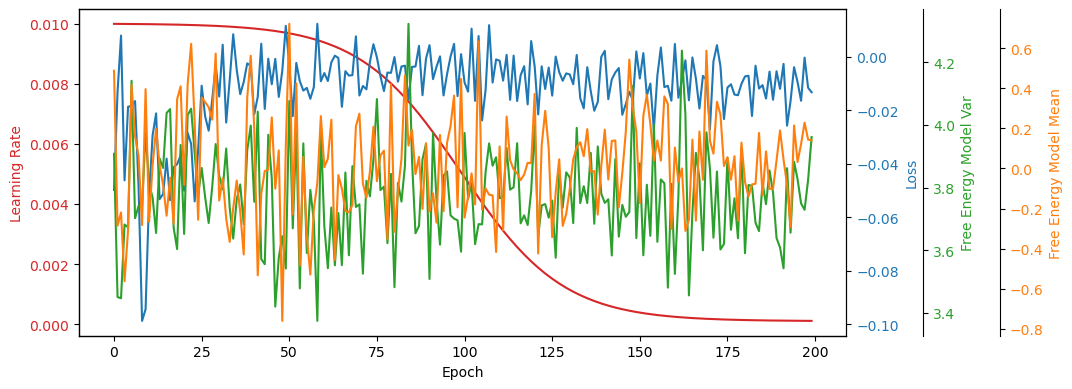

In [15]:
epochs = list(metrics.keys())
loss_vals = [metrics[e]['loss'] for e in epochs]
free_model_mean_vals = [metrics[e]['free_energy_mean'] for e in epochs]
free_model_var_vals = [metrics[e]['free_energy_var'] for e in epochs]
lr_vals = [metrics[e]['lr'] for e in epochs]

fig, ax1 = plt.subplots(figsize=(11, 4))

ax1.plot(epochs, lr_vals, label="Learning Rate", color="tab:red")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Learning Rate", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")

ax2 = ax1.twinx()
ax2.spines["right"].set_position(("axes", 1.00))
ax2.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax2.set_ylabel("Loss", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
ax3.plot(epochs, free_model_var_vals, label="Free Energy Model Var", color="tab:green")
ax3.set_ylabel("Free Energy Model Var", color="tab:green")
ax3.tick_params(axis="y", labelcolor="tab:green")

ax4 = ax1.twinx()
ax4.spines["right"].set_position(("axes", 1.2))
ax4.plot(epochs, free_model_mean_vals, label="Free Energy Model Mean", color="tab:orange")
ax4.set_ylabel("Free Energy Model Mean", color="tab:orange")
ax4.tick_params(axis="y", labelcolor="tab:orange")

plt.tight_layout()
plt.show()

In [16]:
import pandas as pd
import numpy as np
import torch

dense_resolution = 0.05

h_support_vals = [0.50, 0.80, 0.95, 1.00, 1.05, 1.20, 1.50] # the points you trained on
h_novel_vals = np.arange(min(h_support_vals), max(h_support_vals), dense_resolution)
h_novel_vals = np.array([h for h in h_novel_vals if not any(np.isclose(h, s) for s in h_support_vals)])


# Merge and Sort unique values
all_h_values = sorted(list(set(h_support_vals) | set(h_novel_vals)))

eval_samples = 10_000
eval_steps = 200
T_eval = 1.0

# Store results here
results_list = []

model_device = next(model.parameters()).device
model_dtype = next(model.parameters()).dtype  # Detect model dtype (usually float32)

print(f"=== GENERATING DATA ===")
print(f"Total points to evaluate: {len(all_h_values)}")

l_axis = list(range(1, CHAIN_LENGTH // 2 + 1))
rng_eval = torch.Generator(device=model_device).manual_seed(1234)

for i, h_val in enumerate(all_h_values):
    # Determine type for labeling
    pt_type = "support" if any(np.isclose(h_val, s) for s in h_support_vals) else "interpolated"

    # 1. Generate Samples
    # FIX: Explicitly cast to model_dtype to avoid RuntimeError
    cond_gen = torch.tensor([[h_val]], device=model_device, dtype=model_dtype).expand(eval_samples, -1)
    T_schedule = torch.full((eval_steps,), T_eval, device=model_device, dtype=model_dtype)

    with torch.no_grad():
        samples = model.generate(cond_gen, T_schedule, rng_eval)

    # 2. Define Scorer
    cond_score = torch.tensor([[h_val]], device=model_device, dtype=model_dtype)
    scorer = lambda v: model.log_score(v, cond_score)

    # 3. Compute Entropy & Store
    for l in l_axis:
        s2 = compute_renyi_entropy(samples, l, scorer)

        results_list.append({
            "h": float(h_val),
            "l": int(l),
            "s2": float(s2),
            "type": pt_type
        })

    if (i + 1) % 5 == 0:
        print(f"[{i+1}/{len(all_h_values)}] Processed h={h_val:.3f} ({pt_type})")

# Create DataFrame
df_res = pd.DataFrame(results_list)
print("Done. Data stored in 'df_res'.")
print(df_res.head())

=== GENERATING DATA ===
Total points to evaluate: 21
[5/21] Processed h=0.700 (interpolated)
[10/21] Processed h=0.950 (support)
[15/21] Processed h=1.200 (support)
[20/21] Processed h=1.450 (interpolated)
Done. Data stored in 'df_res'.
     h  l        s2     type
0  0.5  1  0.001013  support
1  0.5  2  0.000833  support
2  0.5  3  0.001777  support
3  0.5  4  0.001348  support
4  0.5  5  0.001317  support


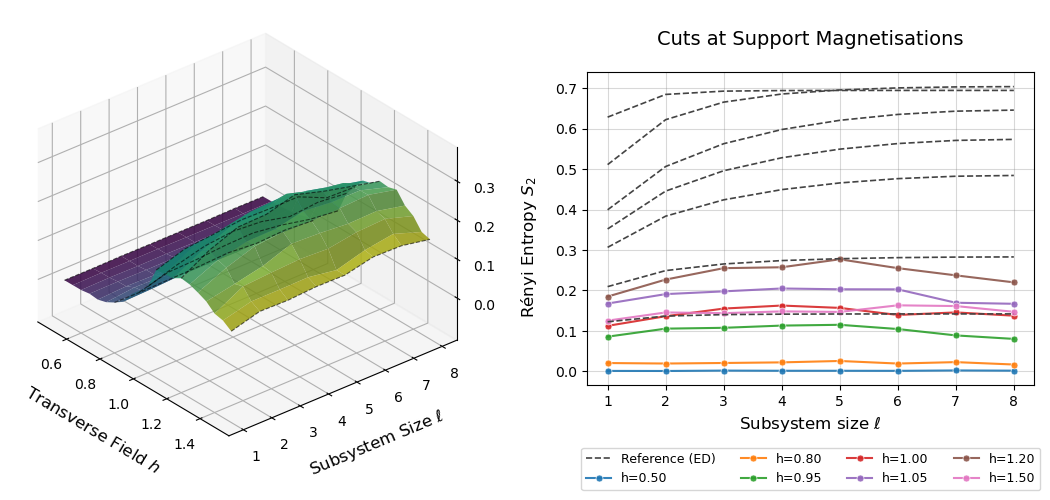

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from pathlib import Path

# --- CONFIGURATION VARIABLES ---
# Layout Controls
PLOT_WSPACE = -0.15        # Distance between the 3D and 2D plots
VERTICAL_OFFSET_2D = 0.02   # Move 2D plot Up (+) or Down (-)

# 2D Plot Geometry
BOX_ASPECT_2D = 0.7        # Height/Width ratio (smaller = flatter)
Y_MAX_2D = 0.7             # Maximum value for Y-axis (Caps the graph)

# Styling/Labels
Z_LABEL_PAD = 9            # Distance of Z-label from 3D plot
TITLE_PAD_2D = 20          # Distance of title from 2D plot

# Legend Controls
LEGEND_NCOL = 4            # Number of columns
LEGEND_X = 0.5             # Horizontal position (0.5 = centered relative to axes)
LEGEND_Y = -0.18           # Vertical position (negative = below x-axis)
# -------------------------------

# --- DATA PREPARATION ---

# 1. Load Reference Data
try:
    chain_length = CHAIN_LENGTH
except NameError:
    chain_length = 16

ref_file = Path(f"tfim_{chain_length}_entropy_ref.csv")
if ref_file.exists():
    ref_df = pd.read_csv(ref_file)
else:
    ref_df = None
    print(f"Warning: {ref_file} not found. Reference lines will be skipped.")

# 2. Process 'df_res' (Generated in previous cell)
# We separate the data into:
#   A. Dense Mesh (for the smooth 3D surface)
#   B. Support Points (for the 2D lines and 3D cuts)

if 'df_res' not in locals():
    raise RuntimeError("df_res not found. Please run the generation cell (Cell 7) first.")

# A. Prepare Dense Data for Surface
pivot_df = df_res.pivot(index='l', columns='h', values='s2')
h_dense = pivot_df.columns.values
l_values = pivot_df.index.values

X_h, Y_l = np.meshgrid(h_dense, l_values)
Z_s2 = pivot_df.values  # Shape matches meshgrid (len(l), len(h))

# B. Identify Support Points for Lines
# We only want to draw lines for h-values marked as 'support' in df_res
support_h_keys = df_res[df_res['type'] == 'support']['h'].unique()
support_h_keys.sort()

# ------------------------

# 4. PLOTTING
fig = plt.figure(figsize=(16, 6))
fig.patch.set_facecolor('white')

# GridSpec
gs = gridspec.GridSpec(1, 2, width_ratios=[1.6, 0.8], wspace=PLOT_WSPACE)

# === SUBPLOT 1: 3D SURFACE (Left) ===
ax3d = fig.add_subplot(gs[0], projection='3d')
ax3d.set_facecolor('white')
ax3d.set_proj_type('ortho')

# Unified Color Map (Viridis for 3D Surface)
# We use the DENSE h values for the normalization so the gradient is smooth
cmap_surface = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=h_dense.min(), vmax=h_dense.max())
surface_colors = cmap_surface(norm(X_h))

# Plot the colored surface background using DENSE data
surf = ax3d.plot_surface(X_h, Y_l, Z_s2, facecolors=surface_colors,
                         rstride=1, cstride=1, shade=True,
                         edgecolor=None, linewidth=0, alpha=0.85, antialiased=True)

# Optional: Add contour on the floor for depth
ax3d.set_zlim(np.min(Z_s2)-0.1, np.max(Z_s2)+0.1)

ax3d.set_xlabel('Transverse Field $h$', fontsize=12, labelpad=10)
ax3d.set_ylabel('Subsystem Size $\\ell$', fontsize=12, labelpad=10)
ax3d.set_zlabel(r'Rényi Entropy $S_2$', fontsize=12, labelpad=Z_LABEL_PAD)

ax3d.view_init(elev=30, azim=-40)

# === SUBPLOT 2: 2D PROJECTION (Right) ===
ax2d = fig.add_subplot(gs[1])
ax2d.set_facecolor('white')

# 1. Apply Aspect Ratio
ax2d.set_box_aspect(BOX_ASPECT_2D)

# 2. Apply Vertical Shift
pos = ax2d.get_position()
new_pos = [pos.x0, pos.y0 + VERTICAL_OFFSET_2D, pos.width, pos.height]
ax2d.set_position(new_pos)

# 3. Define Tab10 Color Cycle for 2D Model Lines
cmap_2d_cycle = plt.get_cmap("tab10")

ref_label_added = False

# We iterate ONLY over the SUPPORT keys for the lines
for i, h in enumerate(support_h_keys):

    # Extract the curve for this specific h from the dataframe
    s2_vals = df_res[df_res['h'] == h].sort_values('l')['s2'].values

    # Use tab10 color based on index
    line_color = cmap_2d_cycle(i % 10)

    # --- 3D PLOTTING: Add Black Dashed Lines on Surface ---
    xs_3d = np.full_like(l_values, h, dtype=float)
    ys_3d = l_values
    zs_3d = s2_vals
    ax3d.plot(xs_3d, ys_3d, zs_3d, color='black', linestyle='--',
              linewidth=0.8, alpha=0.6, zorder=10)

    # --- 2D PLOTTING: Reference (ED) ---
    if ref_df is not None:
        # Check if this specific 'h' exists in the reference dataframe
        mask = np.isclose(ref_df["h"], h, atol=1e-3)
        if mask.any():
            # Find columns that start with 'l' and exist in our plot range (l_values)
            l_cols = sorted([c for c in ref_df.columns if c.startswith("l") and int(c[1:]) in l_values],
                            key=lambda s: int(s[1:]))

            # Extract data
            y_ref = ref_df.loc[mask].iloc[0][l_cols].values

            # The x-axis for ref data must match the columns found
            x_ref = [int(c[1:]) for c in l_cols]

            lbl = "Reference (ED)" if not ref_label_added else "_nolegend_"
            ax2d.plot(x_ref, y_ref, linestyle='--', color='#444444',
                      linewidth=1.2, label=lbl, zorder=5)
            ref_label_added = True

    # --- 2D PLOTTING: RBM Data ---
    ax2d.plot(l_values, s2_vals, marker='o', linestyle='-',
              color=line_color, markersize=5, linewidth=1.5, alpha=0.9,
              markeredgecolor='white', markeredgewidth=0.5,
              label=f"h={h:.2f}", zorder=4)

ax2d.set_xlabel("Subsystem size $\\ell$", fontsize=12)
ax2d.set_ylabel("")
ax2d.set_title("Cuts at Support Magnetisations", fontsize=14, pad=TITLE_PAD_2D)

# LEGEND
ax2d.legend(frameon=True, fontsize=9,
            loc='upper center',
            bbox_to_anchor=(LEGEND_X, LEGEND_Y),
            ncol=LEGEND_NCOL)

ax2d.grid(True, alpha=0.3, color='gray')

plt.show()